### Task 1
# Model Description of YOLO

# You only look once (YOLO) 
It is object detection system targeted for real-time processing. The major concept of YOLO is to build a CNN network to predict a (S, S, B×5 + C) tensor. 
![YOLO makes SxS predictions with B boundary boxes.](https://miro.medium.com/max/4226/1*OuMJUWo2rXYA-GYU63NUGw.jpeg)
#### Benefits
- Fast
- Prediction (object and location) from a single network

## Algorithm
_Input: image_

1. Divide the image into a grid of S x S cells
2. For each grid cell:
   * predict B boundary boxes and each box has one box confidence score (reflects how likely the box contains an object (objectness) and how accurate is the boundary box),
   * detect one object only regardless of the number of boxes B,
   * predict C conditional class probabilities (one per class for the likeliness of the object class).
![Steps of YOLO](https://miro.medium.com/max/3430/1*e0VY6U1_WMF2KBoKQNZvkQ.png)

## Detailed Description
### Grid Cell
  * Each grid cell only predicts one object and a fixed number of bounding boxes for the predicted object.
  * But is has C conditional class probabilities
     * The probability that detected object belongs to a particular class (one probability per category for each cell)
### Bounding Box
  * Each boundary box contains 5 elements: (x, y, w, h) and a box confidence score.
  * The confidence score reflects how likely the box contains an object and how accurate is the boundary box. 
  * We normalize the bounding box width w and height h by the image width and height. x and y are offsets to the corresponding cell. Hence, x, y, w and h are all between 0 and 1.

### Scores:
  * Box confidence score = P(object) * IoU
  * Conditional confidence score = P(class| object)
  * Class confidence score = P(class) * IoU = box confidence score * conditional class probablity (measures the classification and location of the object)
  * Where:
      * P(object) = the probability that the box contains an object.
      * IoU = (Intersection over union) between the bounding box and the ground truth.
      * p(class_i|object) = the probablity the object belongs to the class_i given an object is present
      * p(class_i) = the probability the object belongs to the class_i

### Network structure
![Network design](https://miro.medium.com/max/3840/1*9ER4GVUtQGVA2Y0skC9OQQ.png)
* It uses a CNN network to reduce the spatial dimension to S×S with 1024 output channels at each location.
* Then it preforms linear regression using two fully connected layers to make S×S×B boundary box predictions.
* To make a final prediction, keep those with box confidence scores higher than some treshold as our final predictions.
* So, YOLO’s prediction has a shape of (S, S, B×5 + C)
#### Loss function
* Uses sum-squared error between the predictions and the ground truth to calculate loss.
* It is the sum of **classification loss**, **localisation loss**(errors between the predicted boundary box and the ground truth) and **confidence loss**
  * **classification loss**
![If an object is detected](https://miro.medium.com/max/2908/1*lF6SCAVj5jMwLxs39SCogw.png)
  * **localisation loss**
     * measures the errors in the predicted boundary box locations and sizes. 
     * We only count the box responsible for detecting the object.
![](https://miro.medium.com/max/3196/1*BwhGMvffFfqtND9413oiwA.png)
  * **confidence loss**
     * If object is detected in the box
![If object is detected in the box](https://miro.medium.com/max/3316/1*QT7mwEbyLJYIxTYtOWClFQ.png)
     * If object is not detected in the box
![If object is not detected in the box](https://miro.medium.com/max/3052/1*Yc_OJIXOoV2WaGQ6PqhTXA.png)

### Inference: Non-maximal suppression
* YOLO can make duplicate detections for the same object. To fix this, YOLO applies non-maximal suppression to remove duplications with lower confidence.
* One possible implementation:
   1. Sort the predictions by the confidence scores.
   2. Start from the top scores, ignore any current prediction if we find any previous predictions that have the same class and IoU > 0.5 with the current prediction.
   3. Repeat step 2 until all predictions are checked.



# YOLO v2
YOLOv2 is the second version of the YOLO with the objective of improving the accuracy significantly while making it faster.
## Accuracy improvement
### Batch normalization
Add batch normalization in convolution layers. This removes the need for dropouts and pushes mAP up 2%.
### High resolution classifier
The YOLO training composes of 2 phases. First, we train a classifier network like VGG16. Then we replace the fully connected layers with a convolution layer and retrain it end-to-end for the object detection.YOLO trains the classifier with 224 × 224 pictures followed by 448 × 448 pictures for the object detection. YOLOv2 starts with 224 × 224 pictures for the classifier training but then retune the classifier again with 448 × 448 pictures using much fewer epochs. This makes the detector training easier and moves mAP up by 4%.
### Convolution with Anchor Boxes
Initially, YOLO makes arbitrary guesses on the boundary boxes. These guesses may work well for some objects but badly for others resulting in steep gradient changes. In early training, predictions are fighting with each other on what shapes to specialize on.
![Boundary boxes](https://miro.medium.com/max/1008/1*8Q8r9ixjTiKLi1mrF36xCw.jpeg)

For example, instead of random boxes, we can create 5 anchor boxes with the following shapes and predict offsets to each of the anchor boxes. If we constrain the offset values, we can maintain the diversity of the predictions and have each prediction focuses on a specific shape. So the initial training will be more stable.
### Dimension clusters 
Many domain problems have strong boundary patterns. To identify the top-K boundary boxes that have the best coverage for the training data, we run K-means clustering on the training data to locate the centroids of the top-K clusters using IoU as a distance meassure.

![](https://miro.medium.com/max/2228/1*l5wvrPjLlFp6Whgy0MqbKQ.png)

On the left, we plot the average IoU between the anchors and the ground truth boxes using different numbers of clusters (anchors). As the number of anchors increases, the accuracy improvement plateaus. For the best return, YOLO settles down with 5 anchors. On the right, it displays the 5 anchors’ shapes. The purplish-blue rectangles are selected from the COCO dataset while the black border rectangles are selected from the VOC2007.

Network changes:
- Remove the fully connected layers responsible for predicting the boundary box.
- We move the class prediction from the cell level to the boundary box level. Now, each prediction includes 4 parameters for the boundary box, 1 box confidence score (objectness) and 20 class probabilities. i.e. 5 boundary boxes with 25 parameters: 125 parameters per grid cell.
- To generate predictions with a shape of 7 × 7 × 125, we replace the last convolution layer with three 3 × 3 convolutional layers each outputting 1024 output channels. Then we apply a final 1 × 1 convolutional layer to convert the 7 × 7 × 1024 output into 7 × 7 × 125.
### Direction location prediction
We make predictions on the offsets to the anchors. Nevertheless, if it is unconstrained, our guesses will be randomized again. YOLO predicts 5 parameters (tx, ty, tw, th, and to) and applies the sigma function to constraint its possible offset range.
![](https://miro.medium.com/max/2428/1*gyOSRA_FDz4Pf5njoUb4KQ.jpeg)

Here is the visualization. The blue box below is the predicted boundary box and the dotted rectangle is the anchor.
### Fine-grained features
Convolution layers decrease the spatial dimension gradually. As the corresponding resolution decreases, it is harder to detect small objects. YOLO adopts an approach called passthrough. It reshapes the 26 × 26 × 512 layer to 13 × 13 × 2048. Then it concatenates with the original 13 × 13 ×1024 output layer. Now we apply convolution filters on the new 13 × 13 × 3072 layer to make predictions. 
![](https://miro.medium.com/max/3200/1*RuW-SCIML8SHc5_PrIE9-g.jpeg)
### Multi-scale Training
## Speed improvement
### Replace VGG16 (30.69 billion flops for a single pass over 224 × 224 image) for custom GoogLeNet (8.52 billion flops) at the expense of accuracy drop on the top5
### Further simplification by replacing the CNN backbone with DarkNet (5.58 billion flops)

# YOLO v3
It uses multi-label classification. YOLOv3 replaces the softmax function with independent logistic classifiers to calculate the likeliness of the input belongs to a specific label. Instead of using mean square error in calculating the classification loss, YOLOv3 uses binary cross-entropy loss for each label.
YOLOv3 predicts an objectness score for each bounding box using logistic regression.

YOLOv3 makes 3 predictions per location. Each prediction composes of a boundary box, a objectness and 80 class scores, i.e. N × N × [3 × (4 + 1 + 80) ] predictions.

### Sources:
* [Real-time Object Detection with YOLO, YOLOv2 and now YOLOv3](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088) "YOLO decription" description is essentially a summary of this article!
* [YOLOv2 paper](https://arxiv.org/pdf/1612.08242.pdf)

# Prelude
### Imports

In [3]:
import os, os.path
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from darkflow.net.build import TFNet
import cv2

import json
import xmltodict

from shutil import copy2
import xml.etree.ElementTree as ET

### Remove warnings

In [4]:
# Mutes all the tensorflow warnings. Don't run tensorflow_shutup if you want warnings.
def tensorflow_shutup():
    """
    Make Tensorflow less verbose
    
    Source:
    https://stackoverflow.com/a/54950981
    """
    try:
        # noinspection PyPackageRequirements
        import os
        from tensorflow import logging
        logging.set_verbosity(logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        # Monkey patching deprecation utils to shut it up! Maybe good idea to disable this once after upgrade
        # noinspection PyUnusedLocal
        def deprecated(date, instructions, warn_once=True):
            def deprecated_wrapper(func):
                return func
            return deprecated_wrapper

        from tensorflow.python.util import deprecation
        deprecation.deprecated = deprecated

    except ImportError:
        pass

tensorflow_shutup()

### Check current working directory
When writing to files in other directories the current working directory changes.
Run the code beneath to set the current working directory to the directory this file is placed.

In [5]:
correct_working_dir = "/home/fromsa_jonas_naphat_sondre_tord/inf368-exercise-2/darkflow"

current_working_dir = os.getcwd()
print("Current working directory is: " + current_working_dir)

if current_working_dir != correct_working_dir:
    os.chdir(correct_working_dir)

Current working directory is: /home/fromsa_jonas_naphat_sondre_tord/inf368-exercise-2/darkflow


# Code section
We have selected Yolo V2 as our CNN architecture to perform object recognition. More specifically, Yolo V2 tiny version.

To train, evaluate and further use the Yolo V2 model for object recognition we have chosen to use Darkflow, a network builder adapted from darknet which allows building tensorflow networks from cfg files.
Darkflow repository:
https://github.com/thtrieu/darkflow

The network architecture is saved as a cfg file. The original Tiny Yolo V2 cfg file has been downloaded from darknet's github repository:
https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-tiny.cfg
The number of classes (for the final softmax) and the dimensions of the last convolution has been altered to fit our 10 classes of the SVHN dataset: The numbers 1, 2, 3, 4, 5, 6, 7, 8, 9 and 10 (which is the representation of 0).

Darkflow requires the annotation files to be formatted in PASCAL VOC format (xml). We have aquired the SVHN dataset in this format from:
https://github.com/penny4860/svhn-voc-annotation-format

### Pipeline
1. Preprocessing
2. Build model and train on SVHN dataset
3. Sanity checks. Perform a set of predictions
4. Evaluate model using Mean Average Precission

## 1. Preprocessing
### Balance Dataset
The train dataset of SVHN is currently distributed as such:

0: 4948

1: 13861

2: 10585

3: 8497

4: 7458

5: 6882

6: 5727

7: 5595

8: 5045

9: 4659

Dataset size: 33402

The dataset is has a lot more 1's and 2's than other numbers and is therefore imbalanced. In initial training the network overfitted to these two numbers and was only able to predict on them.

To mitigate these issues we balance the dataset.
Due to time limitations we simply balance the dataset by reducing the number of all classes to the lowest class contribution.

In [6]:
# Paths to model and train dataset
model_path = "cfg/yolo-tiny-10c.cfg"

train_dataset_path = "Images/train"
train_label_path = "Labels/train"

In [7]:
train_balansed_label_path = 'Labels/balansed_train'
train_balansed_dataset_path  = 'Images/balansed_train'

if not os.path.exists(train_balansed_label_path):
    os.makedirs(train_balansed_label_path)
    
if not os.path.exists(train_balansed_dataset_path):
    os.makedirs(train_balansed_dataset_path)

In [17]:
# NB! Do not run this if the balansed dataset is already created!


#Balance dataset 
labels = {str(i) : 0 for i in range(1,11)}
lowest_class = 4659
for label_xml in os.listdir(train_label_path):
    root = ET.parse(train_label_path+'/'+label_xml).getroot()
    under_count = True
    values = list()
    for type_tag in root.findall('object/name'):
        values.append(str(type_tag.text))
        if(labels[type_tag.text]>=lowest_class):
            under_count = False
            break
            
    if(under_count): 
        for value in values:
            labels[value]+=1
    """copy2(train_label_path+'/'+label_xml, train_balansed_label_path)
        copy2(train_dataset_path+'/'+label_xml.replace('.xml','.png'), train_balansed_dataset_path)"""

## 2. Load model and train
Provide spesifications for training: Which model to train, pre-trained weights, hyperparameters and dataset.

In [26]:
epochs = 100
batch_size = 8
learning_rate = 0.0000001 # 1-e7
gpu_precentage = 1.0 # 100 %

options = {"model": model_path,
           "load": -1, # -1 means: Use the weights saved at the last checkpoint
           "batch": batch_size,
           "epoch": epochs,
           "lr": learning_rate,
           "gpu": gpu_precentage,
           "train": True,
           "annotation": train_balansed_label_path,
           "dataset": train_balansed_dataset_path
          }

# Set up network
tfnet = TFNet(options)

Parsing cfg/yolo-tiny-10c.cfg
Loading None ...
Finished in 6.318092346191406e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13

### Train on balansed dataset

In [ ]:
# Train on whole train dataset
tfnet.train()


cfg/yolo-tiny-10c.cfg parsing Labels/balansed_train
Parsing for ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] 
[=============>      ]68%  26858.xmlstep 14464 - loss 3.9711475372314453 - moving ave loss 4.560554743603481
step 14465 - loss 4.008893013000488 - moving ave loss 4.505388570543182
step 14466 - loss 3.8753905296325684 - moving ave loss 4.4423887664521216
step 14467 - loss 4.790397644042969 - moving ave loss 4.477189654211206
step 14468 - loss 3.3154520988464355 - moving ave loss 4.3610158986747285
step 14469 - loss 4.1967573165893555 - moving ave loss 4.3445900404661915
step 14470 - loss 4.425532817840576 - moving ave loss 4.3526843182036306
step 14471 - loss 3.8760480880737305 - moving ave loss 4.305020695190641
step 14472 - loss 5.176375389099121 - moving ave loss 4.392156164581489
step 14473 - loss 4.980358123779297 - moving ave loss 4.4509763605012695
step 14474 - loss 4.429050445556641 - moving ave loss 4.448783769006806
step 14475 - loss 4.622185230255127 - moving

step 14576 - loss 4.9431257247924805 - moving ave loss 4.490817187876593
step 14577 - loss 3.963104248046875 - moving ave loss 4.438045893893621
step 14578 - loss 3.936490058898926 - moving ave loss 4.387890310394152
step 14579 - loss 2.8202567100524902 - moving ave loss 4.231126950359986
step 14580 - loss 5.4742536544799805 - moving ave loss 4.355439620771985
step 14581 - loss 3.4192073345184326 - moving ave loss 4.26181639214663
step 14582 - loss 5.349785804748535 - moving ave loss 4.370613333406821
step 14583 - loss 3.5811333656311035 - moving ave loss 4.291665336629249
step 14584 - loss 5.374655723571777 - moving ave loss 4.399964375323502
step 14585 - loss 4.500422477722168 - moving ave loss 4.410010185563369
step 14586 - loss 3.864504337310791 - moving ave loss 4.3554596007381114
step 14587 - loss 3.109126567840576 - moving ave loss 4.230826297448358
step 14588 - loss 4.498743057250977 - moving ave loss 4.25761797342862
step 14589 - loss 4.228296279907227 - moving ave loss 4.2546

step 14690 - loss 4.4112467765808105 - moving ave loss 4.409973275459519
step 14691 - loss 4.740041732788086 - moving ave loss 4.442980121192376
step 14692 - loss 4.683777332305908 - moving ave loss 4.467059842303729
step 14693 - loss 4.757555961608887 - moving ave loss 4.4961094542342455
step 14694 - loss 4.238229274749756 - moving ave loss 4.470321436285796
step 14695 - loss 4.6217041015625 - moving ave loss 4.485459702813467
step 14696 - loss 3.549086093902588 - moving ave loss 4.39182234192238
step 14697 - loss 4.960400104522705 - moving ave loss 4.448680118182413
step 14698 - loss 4.14244270324707 - moving ave loss 4.418056376688878
step 14699 - loss 5.330097675323486 - moving ave loss 4.509260506552339
step 14700 - loss 3.7322261333465576 - moving ave loss 4.431557069231761
step 14701 - loss 4.313218593597412 - moving ave loss 4.419723221668327
step 14702 - loss 4.32772159576416 - moving ave loss 4.41052305907791
step 14703 - loss 4.433252334594727 - moving ave loss 4.41279598662

# 3. Prediction - Sanity checks
Try to predict on some images

### Load from checkpoint
Darkflow generates checkpoint files as it trains. To load the weights saved at the last checkpoint, run the code beneath.
"load": -1 tells the system to use the last checkpoint file.
Threshold = 0.2, meaning that if the model predicts an object with probability over 20 % it will give a result: label + bounding box

In [138]:
checkpoint = -1 # 18682

options = {"model": model_path,
           "load": checkpoint,
           "gpu": 1.0,
           "json": True,
           "threshold": 0.2
          }
           
tfnet2 = TFNet(options)
tfnet2.load_from_ckpt()

Parsing cfg/yolo-tiny-10c.cfg
Loading None ...
Finished in 0.00010848045349121094s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 1

In [129]:
def set_box(original_img , predictions):
    '''Add bounding box and label to image'''
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label']
        
        newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 1)
        newImage = cv2.putText(newImage, label, (top_x-5, top_y+12), 1, 1, (0, 250, 0), 1)
        
    return newImage

In [130]:
def load_image(image_path):
    '''Get image from path'''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [131]:
def show_images(images):
    '''Show several images'''
    fig=plt.figure(figsize=(25, 25))
    columns = 4
    rows = 5
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        img = images[i-1]
        plt.imshow(img)
    plt.show()

### Original Image and Prediction
Show an image and the prediction on the image

279
[{'label': '1', 'confidence': 0.31544095, 'topleft': {'x': 37, 'y': 0}, 'bottomright': {'x': 47, 'y': 46}}, {'label': '1', 'confidence': 0.26535755, 'topleft': {'x': 44, 'y': 0}, 'bottomright': {'x': 54, 'y': 45}}]


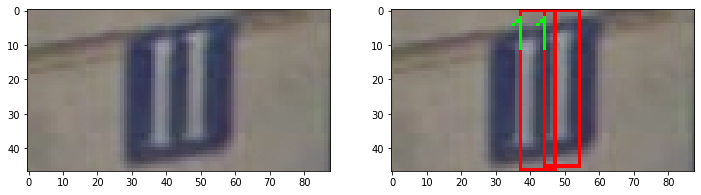

In [132]:
# Print image with and without label and confidence
image_path = train_dataset_path + "/279.png"
image = load_image(image_path)
results = tfnet2.return_predict(image)

new_and_old_image = [image, set_box(image, results)]
show_images(new_and_old_image)

## Unseen data
Predict on unseen data from the test dataset. Display the first 20 images where a prediction was made

In [133]:
test_dataset_path = "Images/test"

In [147]:
# Store predictions for the 20 first images that have a prediction

# Number of images in test dataset
n_images = len(os.listdir(test_dataset_path))

images = []
image_attemps = 0
prediction_count = 0
i = 1
while (prediction_count < 20):
    image_path = test_dataset_path + "/" + str(i) + ".png"
    i += 1
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = tfnet2.return_predict(image)
    if len(results) != 0:
        print(i)
        prediction_count += 1
        image_bbox = set_box(image, results)
        images.append(image_bbox)

The model managed to predict on 20 out of 982


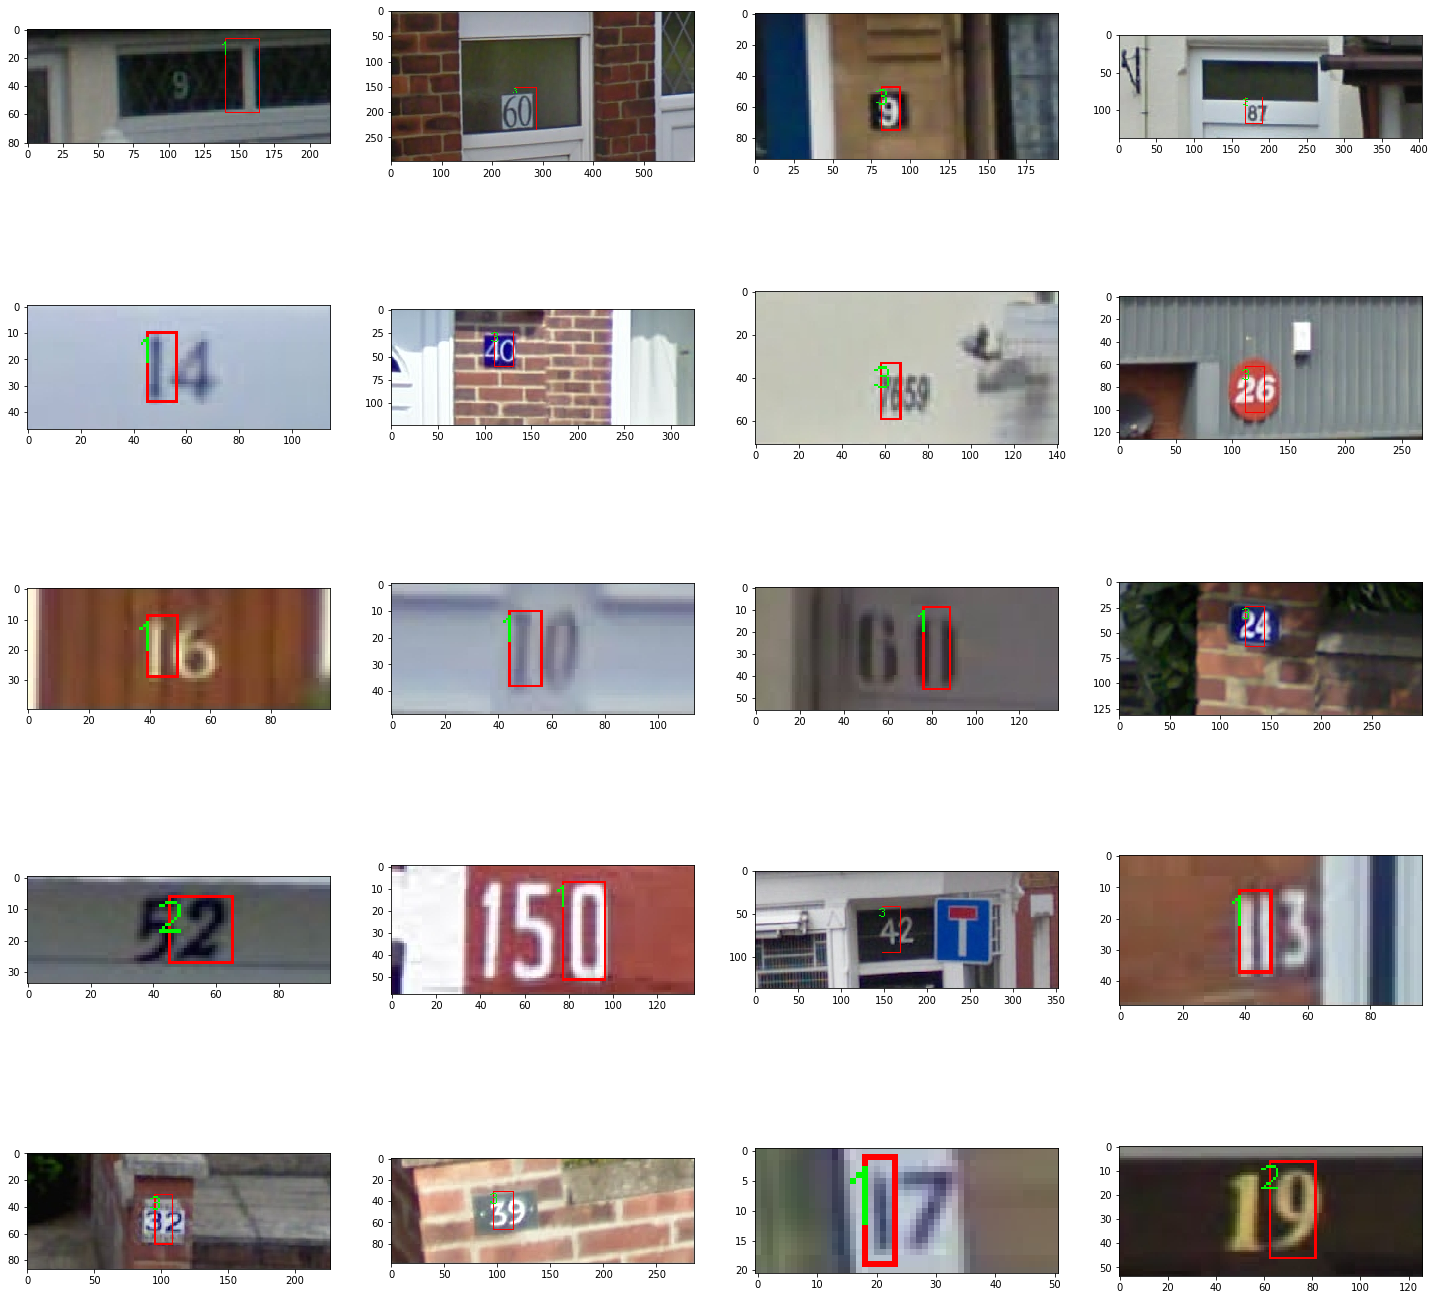

In [140]:
print("The model managed to predict on " + str(prediction_count) + " out of " + str(i-1))
show_images(images)

# 4. Evaluate the model
To evaluate the performance of the neural network we will use the mAP criterium, Mean Average Precission, as defined in the PASCAL VOC 2012 competition.
### Write predictions to JSON
To evaluate the model we will calculate the mean Average Precission (mAP) on the test dataset. Firstly we predict labels and bounding boxes on the test dataset and store the predictions in json files. Then we preceed to convert the json files to appropriate txt files for the calculation of mAP.

To convert the files to json and then calcualte the mean Average Precision we are using code from:
https://github.com/Cartucho/mAP

In [143]:
# Number of images in test dataset
n_images = len(os.listdir(test_dataset_path))

# Path for where to put the json files
json_dir = "mAP/input/detection-results" 

# For each predicton on an image, create a Json file with prediction
for i in range(9948, n_images+1):
    try:
        image_path = test_dataset_path + "/" + str(i) + ".png"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = tfnet2.return_predict(image)
        if len(results) != 0: 
            print("Prediction on image: " + str(i) + ".png")
            with open(json_dir + "/" + str(i) + '.json', 'w+') as f:
                json.dump(str(results), f, ensure_ascii=False)
    except:
        continue

Prediction on image: 9948.png
Prediction on image: 10039.png
Prediction on image: 10043.png
Prediction on image: 10119.png
Prediction on image: 10131.png
Prediction on image: 10252.png
Prediction on image: 10285.png
Prediction on image: 10286.png
Prediction on image: 10298.png
Prediction on image: 10316.png
Prediction on image: 10556.png
Prediction on image: 10638.png
Prediction on image: 10698.png
Prediction on image: 10770.png
Prediction on image: 10814.png
Prediction on image: 10887.png
Prediction on image: 10940.png
Prediction on image: 11093.png
Prediction on image: 11098.png
Prediction on image: 11118.png
Prediction on image: 11120.png
Prediction on image: 11131.png
Prediction on image: 11135.png
Prediction on image: 11159.png
Prediction on image: 11178.png
Prediction on image: 11251.png
Prediction on image: 11282.png
Prediction on image: 11350.png
Prediction on image: 11360.png
Prediction on image: 11498.png
Prediction on image: 11581.png
Prediction on image: 11622.png
Predictio

In [125]:
# Convert correct labels (ground truths)
%run ./mAP/scripts/extra/convert_gt_xml.py
os.chdir(correct_working_dir)

Conversion completed!


In [144]:
# Convert Json prediction files to txt files
%run ./mAP/scripts/extra/convert_dr_darkflow_json.py
os.chdir(correct_working_dir)

Conversion completed!


<Figure size 432x288 with 0 Axes>

In [145]:
# Move all images that do not have a prediction to a sepearate folder before calculating mAP
%run ./mAP/scripts/extra/intersect-gt-and-dr.py
os.chdir(correct_working_dir)

total ground-truth files: 1348
total detection-results files: 245

total ground-truth backup files: 1321
total detection-results backup files: 218
total intersected files: 27
Intersection completed!


### Calculate mean Average Precision

37.35% = 1 AP 
0.00% = 10 AP 
14.29% = 2 AP 
1.10% = 3 AP 
0.00% = 4 AP 
0.00% = 5 AP 
0.00% = 6 AP 
0.00% = 7 AP 
0.00% = 8 AP 
mAP = 5.86%


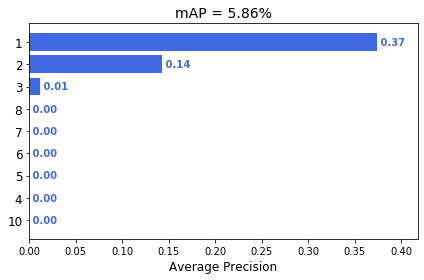

In [146]:
%run ./mAP/main.py -na
os.chdir(correct_working_dir)

## Conclusion
When training our model we quickly discovered that the loss stopped reducing when it got to around 4.0. Efforts where made to fix this issue, such as:
 * Training for longer
 * Start training by overfitting to a few images (11) containing all classes. Then preceed to train on the entire train dataset. This was a tips given by the author of darkflow: https://github.com/thtrieu/darkflow/issues/80#issuecomment-286017921
This resulted in the loss reducing to about 3.5.

With this model the sanity checks did not look too promising. With a threshold of 20 % the model predicted on 20 out of 982  unseen images (2.03 %) giving many erronous predictions.

Calculating the Mean Average Precision we can see the precision of each class (graph above).
Note that this does not take into consideration the images that where not predicted on due to the confidence value of their prediction falling under the threshold of 20 %.

The result is not great. A mAP of 5.86 % is quit low.

### Improvements
To improve the performance of the model in further work we could:
 * Change architecture. We elected Yolo V2 tiny due to time restraints. Initially we used the regular Yolo V2, but quickly saw that training took way too long. It seems that Yolo V2 tiny is not complex enough for SVHN.
 * Train for longer.
 * Use another API. It seems that many people using Darkflow have this issue of the loss becoming stagnant at some value (3.5 in our case). 
 

### Previous models
Earlier versions of the model trained on the complete SVHN train dataset, which was imbalanced having a lot more 1's and 2's. These models were quit good at predicting, but only predicted on 1's and 2's. Thinking we could create a better model when using a balanced dataset, we threw away those models.